**Code for Speech Recognition using Convintional Neural Network**

In [ ]:
#This cell contains code for class *DatasetGeneretor*. Its object will be considered for whole program

#Import all necessory lib functions
import os
import numpy as np
import pandas as pd
import random

from glob import glob
from scipy.io import wavfile
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

class DatasetGenerator():
    # Declare constructor to initialise all the lables
    def __init__(self, label_set, 
                 sample_rate=16000):
        
        self.label_set = label_set
        self.sample_rate = sample_rate
            
    # Covert string to numerical classes              
    def text_to_labels(self, text):
        return self.label_set.index(text)
    
    # Reverse translation of numerical classes back to characters or strings
    def labels_to_text(self, labels):
        return self.label_set[labels]               
        
    # Create dataframe and loading of data
    def load_data(self, DIR):

        # Get all paths inside DIR that ends with wav
        wav_files = glob(os.path.join(DIR, '*/*wav'))
        wav_files = [x.split(sep='\\')[1] + '/' + x.split(sep='\\')[2] for x in wav_files]
        
        # Loop over files to get samples
        data = []
        for e in wav_files:
            label, name = e.split('/')
            if label in self.label_set:
                label_id = self.text_to_labels(label)
                fle = os.path.join(DIR, e)
                sample = (label, label_id, name, fle)
                data.append(sample)
            
        # Data Frames with samples: labels and paths     
        df = pd.DataFrame(data, columns = ['label', 'label_id', 'user_id', 'wav_file'])
        
        # Assign created dataframe to object's dataframe 
        self.df = df
        
        return self.df

    # Train test split to split df
    def apply_train_test_split(self, test_size, random_state):
        
        self.df_train, self.df_test = train_test_split(self.df, 
                                                       test_size=test_size,
                                                       random_state=random_state)
    # Train valide split to avoid model overfitting   
    def apply_train_val_split(self, val_size, random_state):
        
        self.df_train, self.df_val = train_test_split(self.df_train, 
                                                      test_size=val_size, 
                                                      random_state=random_state)
    
    # Function to read wav file
    def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        _, wav = wavfile.read(x) 
        # Normalize
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            
        return wav
    
    # Function to pre-process wav file
    def process_wav_file(self, x, threshold_freq=5500, eps=1e-10):
        # Read wav file to array
        wav = self.read_wav_file(x)
        # Sample rate
        L = self.sample_rate
        # If longer then randomly truncate
        if len(wav) > L:
            i = np.random.randint(0, len(wav) - L)
            wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
        elif len(wav) < L:
            rem_len = L - len(wav)
            silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
            j = np.random.randint(0, rem_len)
            silence_part_left  = silence_part[0:j]
            silence_part_right = silence_part[j:rem_len]
            wav = np.concatenate([silence_part_left, wav, silence_part_right])
        # Create spectrogram using discrete FFT (change basis to frequencies)
        freqs, times, spec = stft(wav, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
        # Cut high frequencies
        if threshold_freq is not None:
            spec = spec[freqs <= threshold_freq,:]
            freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
        amp = np.log(np.abs(spec)+eps)
    
        return np.expand_dims(amp, axis=2) 
    
    # Function to generate batches 
    def generator(self, batch_size, mode):
        while True:
            # Depending on mode select DataFrame with paths
            if mode == 'train':
                df = self.df_train 
                ids = random.sample(range(df.shape[0]), df.shape[0])
            elif mode == 'val':
                df = self.df_val
                ids = list(range(df.shape[0]))
            elif mode == 'test':
                df = self.df_test
                ids = list(range(df.shape[0]))
            else:
                raise ValueError('The mode should be either train, val or test.')
                
            # Create batches (for training data the batches are randomly permuted)
            for start in range(0, len(ids), batch_size):
                X_batch = []
                if mode != 'test': 
                    y_batch = []
                end = min(start + batch_size, len(ids))
                i_batch = ids[start:end]
                for i in i_batch:
                    X_batch.append(self.process_wav_file(df.wav_file.values[i]))
                    if mode != 'test':
                        y_batch.append(df.label_id.values[i])
                X_batch = np.array(X_batch)

                if mode != 'test':
                    y_batch = to_categorical(y_batch, num_classes = len(self.label_set))
                    yield (X_batch, y_batch)
                else:
                    yield X_batch


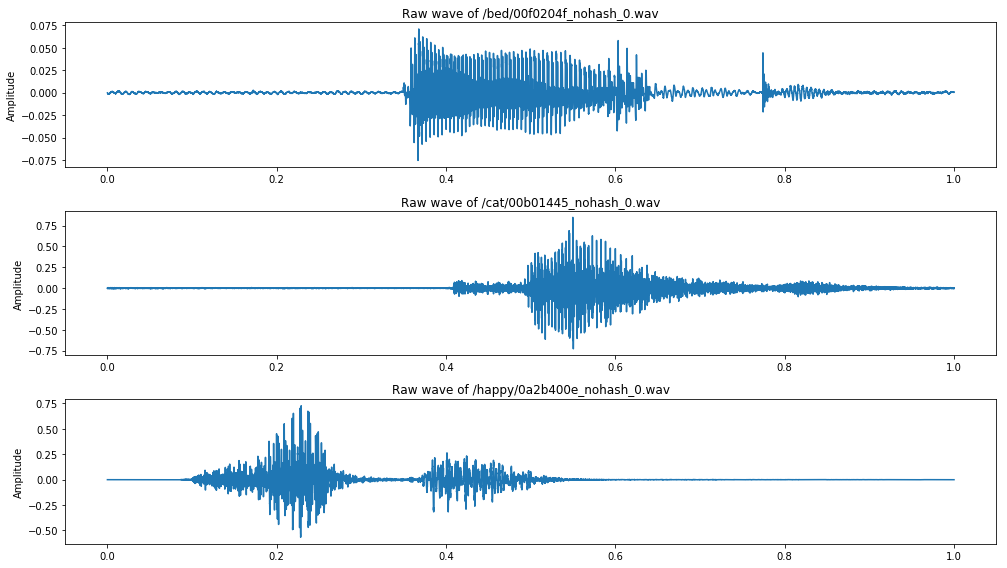

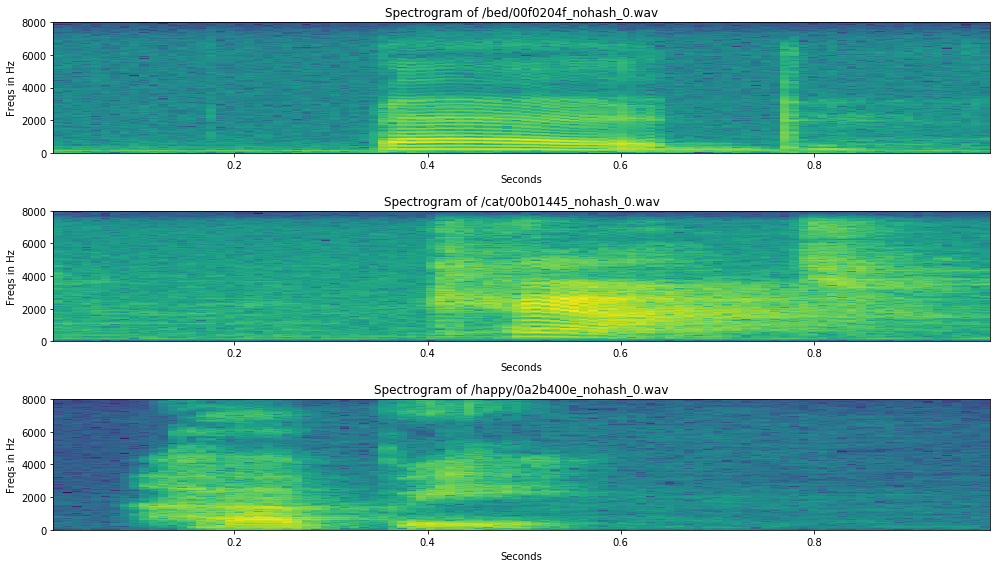

In [5]:
# Import lib functions
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# The following code snippet produces wave plots of few arbitrarily selected commands.
# Path to the training dataset
DIR = 'D:/New folder'
fns = ['/bed/00f0204f_nohash_0.wav',
       '/cat/00b01445_nohash_0.wav',
       '/happy/0a2b400e_nohash_0.wav']

SAMPLE_RATE = 16000

def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
 
    ax = fig.add_subplot(3,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()


# The following code snippet produces the log-spectrograms of few arbitrarily selected commands.
from scipy.signal import stft
 
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(3,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()


In [ ]:

from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

 
DIR = 'D:/college/TRF/LEVEL-II/Task_2/New folder'
 
INPUT_SHAPE = (177,98,1)
BATCH = 10
EPOCHS = 15

# Declear all the lables to be predicted
LABELS = 'backward bed bird cat dog down eight five follow forward four go happy house learn left marvin nine no off on one right seven sheila six stop three tree two visual wow yes zero'.split()
NUM_CLASSES = len(LABELS)
print(NUM_CLASSES)


dsGen = DatasetGenerator(label_set=LABELS) 

# Load DataFrame with paths/labels 
df = dsGen.load_data(DIR)

# Split the data into train - for training model, val - to avoid overfitting, test - for accuracy score 
dsGen.apply_train_test_split(test_size=0.1, random_state=2018)
dsGen.apply_train_val_split(val_size=0.1, random_state=2018)


In [ ]:
# Following block of code builts cnn model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
                          
def deep(features_shape, num_classes, act='relu'):

    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(512, activation=act, name='dense1')(o)
    o = Dense(512, activation=act, name='dense2')(o)
    o = Dense(512, activation=act, name='dense3')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
 
def deep_cnn(features_shape, num_classes, act='relu'):
 
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)
 
    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)
 
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
 
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)


model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
# callbacks is used to avoid overfitting
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]

# Following code is training the data
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))


In [ ]:

#Reading audio from user
import pyaudio
import wave

# Hyperparameters
CHUNK = 1024
FORMAT = pyaudio.paInt16 
CHANNELS = 1
RATE = 16000 #sample rate
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "D:/college/TRF/LEVEL-II/Task_2/New folder/on/new.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")
#print(frames)
stream.stop_stream()
stream.close()
p.terminate()

# Saving the wav file
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()
# End of reading audio

# Playing the audio to check the recorded audio
print("* playing")
from pydub.playback import play 
from pydub import AudioSegment
audio = AudioSegment.from_wav(WAVE_OUTPUT_FILENAME)
play(audio)

# Preprocessing the recorded audio file
from scipy.io.wavfile import read
threshold_freq=5500 
eps=1e-10
wav = (read(WAVE_OUTPUT_FILENAME))[1]

# Spliting the sentence in recorded audio to different audio's containing single word
from pydub.silence import split_on_silence
sound_file = AudioSegment.from_wav(WAVE_OUTPUT_FILENAME)
audio_chunks = split_on_silence(sound_file, 
    # must be silent for at least half a second
    min_silence_len=100,

    # consider it silent if quieter than silence_thresh dBFS
    silence_thresh=-35
)
count = 0
for i, chunk in enumerate(audio_chunks):
    out_file = "D:/college/TRF/LEVEL-II/Task_2/New folder/chunk{0}.wav".format(i)
    print ("exporting", out_file)
    chunk.export(out_file, format="wav")
    count += 1

# Adding splited audio files into dataframe
import pandas as pd
e = "on/new.wav"
label, name = e.split('/')
label_id = dsGen.text_to_labels(label)
for j in range(count):
    fle = "D:/college/TRF/LEVEL-II/Task_2/New folder/chunk{0}.wav".format(j)
    sample = (label, label_id, name, fle)
    n_df = pd.DataFrame(data = [sample],columns = ['label', 'label_id', 'user_id', 'wav_file'])
    dsGen.df_test = dsGen.df_test.append(n_df)


In [ ]:
dsGen.df_test = dsGen.df_test[-count:]             #Run only if you want to output your audio file. Do not run if you want to check accuracy

In [ ]:
# Following block of code predicts the lable of input audio file
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)

y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dsGen.df_test['label_id'].values

# Prediict assuracy score using test data
acc_score = accuracy_score(y_true, y_pred)    
print(acc_score)                        

In [ ]:
# Following block of code prints lables by decoding lable id
ans = []
print("You Said: ")
for j in range(count):
    ans.append(dsGen.labels_to_text(y_pred[len(dsGen.df_test) - 1 - j]))
    print(dsGen.labels_to_text(y_pred[j]),end = " ")